## VoxelMorph NoteBook 

#### Reference
* Many of the code were made by K Scott Mader at Kaggle  https://www.kaggle.com/kmader
* Original Notebook: https://www.kaggle.com/kmader/voxelmorph-demo
* Used pretrained Model from https://github.com/voxelmorph/voxelmorph

### The prediction on our dataset start from the markdown cell "MSK Sample Data"

##### Resize
* Goal: From (320, 320, 192) to (160, 192, 224). 
* There do not seem to exist packages to adjust the third entry. 
* So, currently all the missing 32 arrays are entered as zeros. 

In [1]:
%matplotlib inline
import os, sys
import glob

import tensorflow as tf
import scipy.io as sio
import numpy as np
import nibabel as nib
import keras
from keras.backend.tensorflow_backend import set_session
from scipy.interpolate import interpn # trasformation
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Change this path as you need.
vm_dir = './'

sys.path.append(os.path.join(vm_dir, 'src')) 
sys.path.append(os.path.join(vm_dir, 'ext', 'medipy-lib'))
sys.path.append(os.path.join(vm_dir, 'ext', 'neuron'))
sys.path.append(os.path.join(vm_dir, 'ext', 'pynd-lib'))
sys.path.append(os.path.join(vm_dir, 'ext', 'pytools-lib'))

import medipy
import networks, losses
from medipy.metrics import dice
import datagenerators
import neuron.layers as nrn_layers # import this at last

In [5]:
# Need to modify 

vol_size=(160,192,224)
nf_enc=[16,32,32,32]
nf_dec=[32,32,32,32,32,16,16,3]

### Load Atlas Data

* Here is the atlas dataset that we load as our reference or fixed-image against which we register everything else. 
* We load the labels as well since they help with the DICE scoring later.

In [6]:
labels = sio.loadmat(os.path.join(vm_dir, 'data', 'labels.mat'))['labels'][0]

In [12]:
atlas = np.load(os.path.join(vm_dir, 'data', 'atlas_norm.npz'))
atlas_vol = atlas['vol']
atlas_seg = atlas['seg']
atlas_vol = np.expand_dims(np.expand_dims(atlas_vol, 0), -1)
print(atlas_vol.shape, atlas_seg.shape)
# print(np.amax(atlas_vol))
# print(max(atlas_vol.flatten()))

(1, 160, 192, 224, 1) (160, 192, 224)


#### Atlas

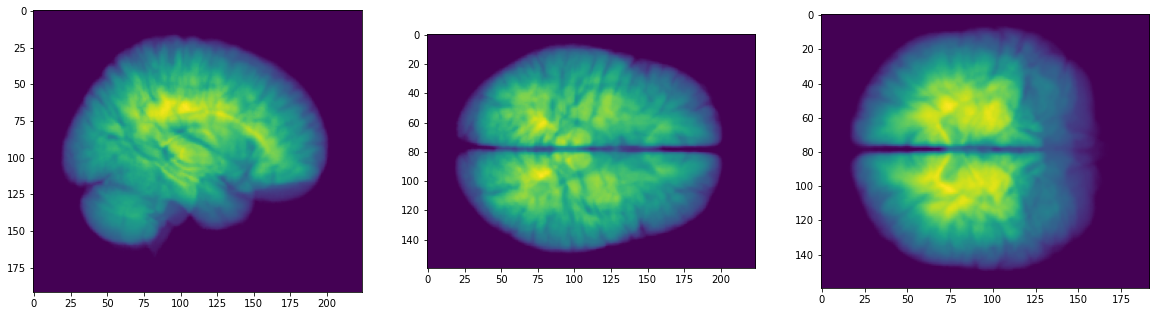

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
# For [0, :(avg), x, y, 0]
ax1.imshow(np.mean(atlas_vol[0, :, :, :, 0], 0))
# For [0, x, :(avg), y, 0]
ax2.imshow(np.mean(atlas_vol[0, :, :, :, 0], 1))
# For [0, x, y, :(avg), 0]
ax3.imshow(np.mean(atlas_vol[0, :, :, :, 0], 2))

#### Atlas_seg

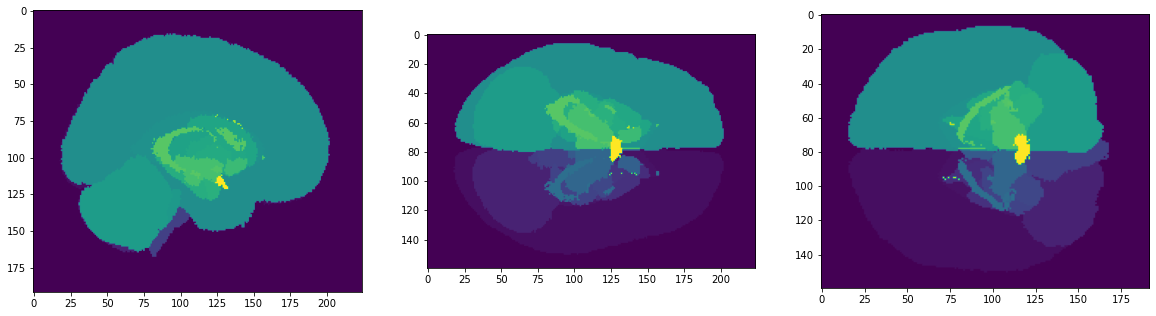

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(atlas_seg, 0))
ax2.imshow(np.max(atlas_seg, 1))
ax3.imshow(np.max(atlas_seg, 2))

### Load Model

In [15]:
mdl = os.path.join(vm_dir, 'models',  'cvpr2018_vm2_l2.h5') # Pretrained model 

custom_objects = {'SpatialTransformer': nrn_layers.SpatialTransformer,
                 'VecInt': nrn_layers.VecInt,
                 'Sample': networks.Sample,
                 'Rescale': networks.RescaleDouble,
                 'Resize': networks.ResizeDouble,
                 'Negate': networks.Negate,
                 'recon_loss': losses.Miccai2018(0.02, 10).recon_loss, # values shouldn't matter
                 'kl_loss': losses.Miccai2018(0.02, 10).kl_loss        # values shouldn't matter
                 }
net = keras.models.load_model(mdl, custom_objects=custom_objects)




Here









C:\Users\Yixing\Anaconda3\envs\voxelmorph\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 160, 192, 224 0                                            
__________________________________________________________________________________________________
concatenate_31 (Concatenate)    (None, 160, 192, 224 0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
conv3d_67 (Conv3D)              (None, 80, 96, 112,  880         concatenate_31[0][0]             
__________

### Load Test Data

In [17]:
xx = np.arange(vol_size[1])
yy = np.arange(vol_size[0])
zz = np.arange(vol_size[2])
grid = np.rollaxis(np.array(np.meshgrid(xx, yy, zz)), 0, 4)

In [18]:
# import datagenerators
X_vol, X_seg = datagenerators.load_example_by_name(
    os.path.join(vm_dir, 'data', 'test_vol.npz'), 
    os.path.join(vm_dir, 'data', 'test_seg.npz')
)
print(X_vol.shape, X_seg.shape)
print(np.amax(X_vol))
# data = np.load(os.path.join(vm_dir, 'data', 'test_vol.npz'))
# print(data.files)

(1, 160, 192, 224, 1) (1, 160, 192, 224, 1)
0.9764705882352941


## Example One

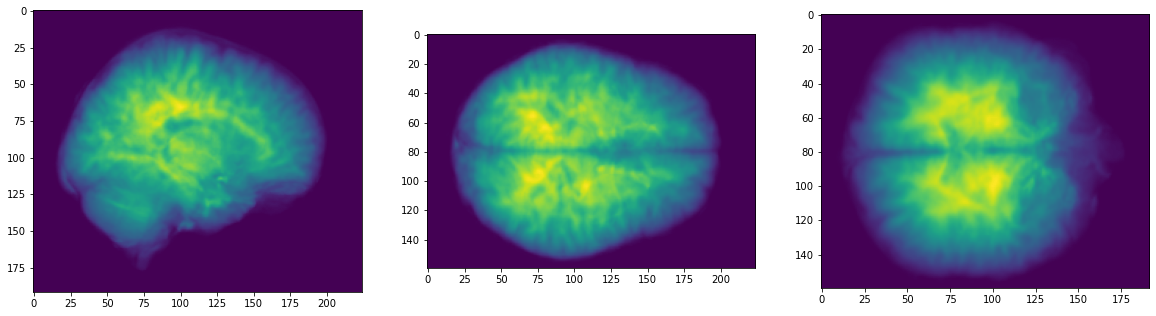

In [19]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(X_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(X_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(X_vol[0, :, :, :, 0], 2))

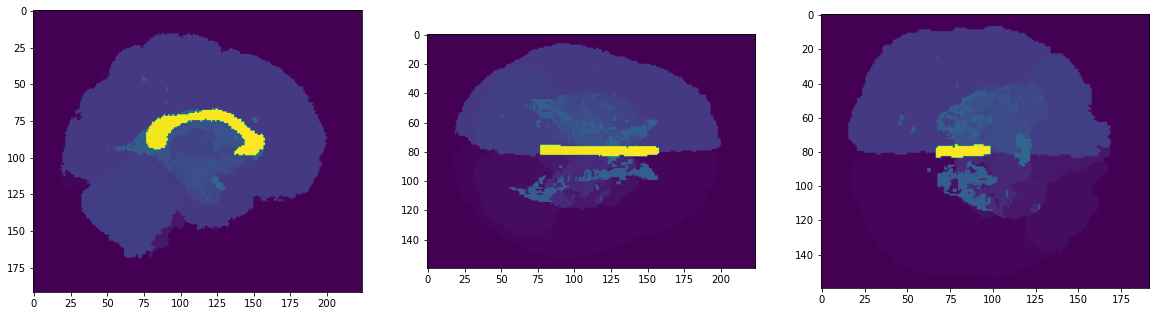

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.max(X_seg[0, :, :, :, 0], 0))
ax2.imshow(np.max(X_seg[0, :, :, :, 0], 1))
ax3.imshow(np.max(X_seg[0, :, :, :, 0], 2))

In [21]:
print(X_vol.shape)
print(atlas_vol.shape)

(1, 160, 192, 224, 1)
(1, 160, 192, 224, 1)


In [40]:
%%time
pred = net.predict([X_vol, atlas_vol])

Wall time: 4.8 s


In [18]:
len(pred)

2

### Show displacement maps

13.531762
1.5481094


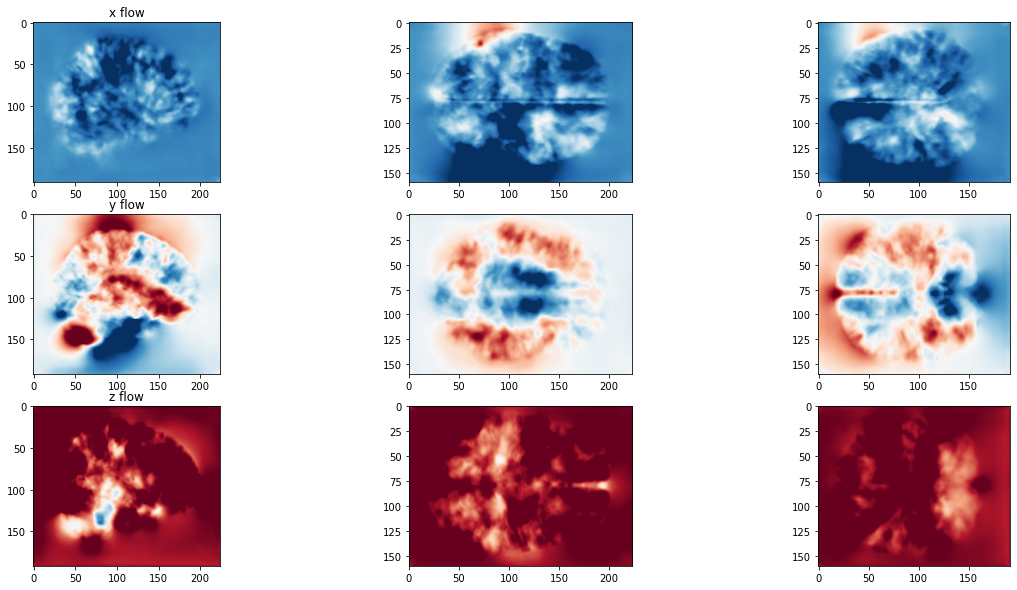

In [41]:
# Warp segments with flow
flow = pred[1][0, :, :, :, :]
flow_sd = np.std(flow)
print(np.amax(flow))
print(flow_sd)
v_args = dict(cmap = 'RdBu', vmin = -flow_sd, vmax = +flow_sd)
fig, m_axs = plt.subplots(3, 3, figsize = (20, 10))
for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(np.mean(flow[:, :, :, i], 0), **v_args)
    ax1.set_title('xyz'[i]+' flow')
    ax2.imshow(np.mean(flow[:, :, :, i], 1), **v_args)
    ax3.imshow(np.mean(flow[:, :, :, i], 2), **v_args)

### Show flow field

In [20]:
def meshgridnd_like(in_img,
                    rng_func=range):
    new_shape = list(in_img.shape)
    all_range = [rng_func(i_len) for i_len in new_shape]
    return tuple([x_arr.swapaxes(0, 1) for x_arr in np.meshgrid(*all_range)])

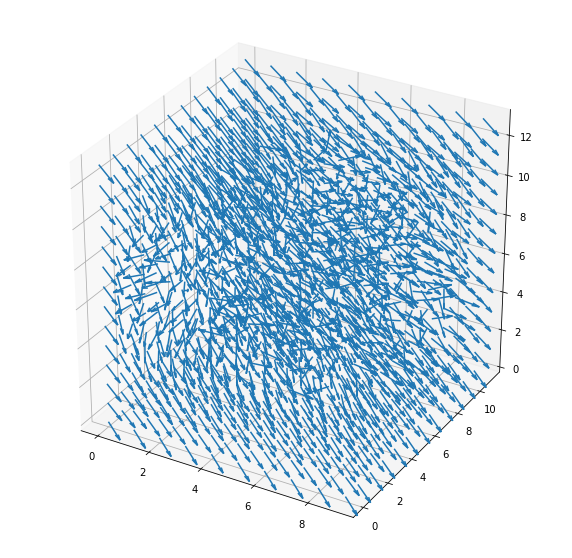

In [43]:
from mpl_toolkits.mplot3d import axes3d
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.9,
          normalize=True)

* What does the dice score represent? 

In [44]:
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
warp_seg = interpn((yy, xx, zz), X_seg[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)
warp_vol = interpn((yy, xx, zz), X_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)

vals, _ = dice(warp_seg, atlas_seg, labels=labels, nargout=2)
print('DICE Scores for various labels:', np.mean(vals), np.std(vals))

DICE Scores for various labels: 0.6428887038050166 0.1474690433354022


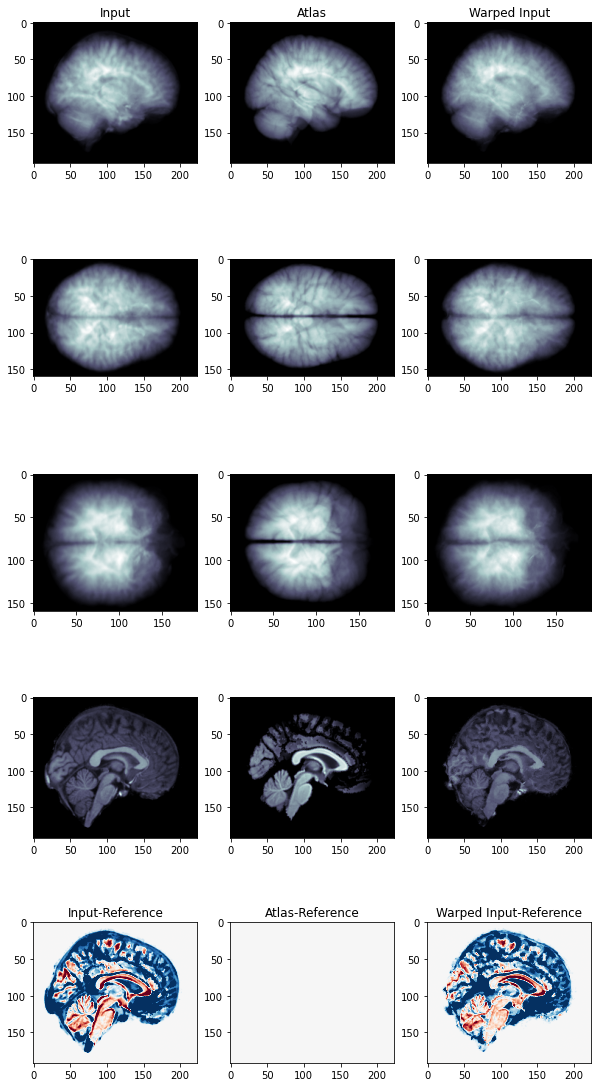

In [45]:
fig, m_axs = plt.subplots(5, 3, figsize = (10, 20))
mid_slice = X_vol.shape[1]//2
for (ax1, ax2, ax3, ax4, ax5), c_vol, c_label in zip(
    m_axs.T, 
    [X_vol, atlas_vol, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
):
    ax1.imshow(np.mean(c_vol[0, :, :, :, 0], 0), cmap = 'bone')
    ax1.set_title(c_label)
    ax2.imshow(np.mean(c_vol[0, :, :, :, 0], 1), cmap = 'bone')
    ax3.imshow(np.mean(c_vol[0, :, :, :, 0], 2), cmap = 'bone')
    ax4.imshow(c_vol[0, mid_slice, :, :, 0], cmap = 'bone')
    
    ax5.imshow(c_vol[0, mid_slice, :, :, 0]-atlas_vol[0, mid_slice, :, :, 0], 
               cmap = 'RdBu', vmin = -np.std(c_vol), vmax = np.std(c_vol))
    ax5.set_title('{}-Reference'.format(c_label))

### Really Screwy Volume (Example Two) 
* We now move the volume a whole bunch manually and see if the model recovers the values it should. 
* We create a Y_vol and try and register it to an X_vol

0.9764705882352941


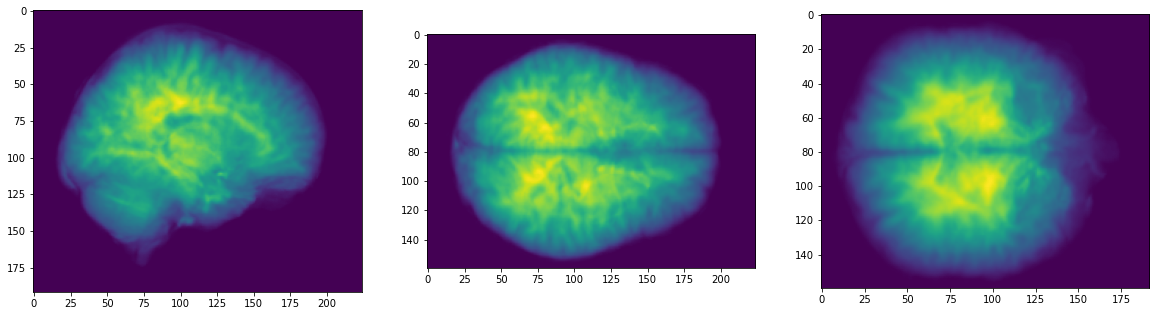

In [46]:
Y_vol = np.roll(X_vol, shift = -3, axis = 2)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(Y_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(Y_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(Y_vol[0, :, :, :, 0], 2))
print(np.amax(Y_vol))

In [47]:
%%time
pred = net.predict([Y_vol, X_vol])

Wall time: 4.4 s


In [48]:
flow = pred[1][0, :, :, :, :]
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
print('Average x displacement:', np.mean(flow[:, :, :, 0]))

Average x displacement: 0.67751956


### Registration

In [49]:
warp_vol = interpn((yy, xx, zz), Y_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)

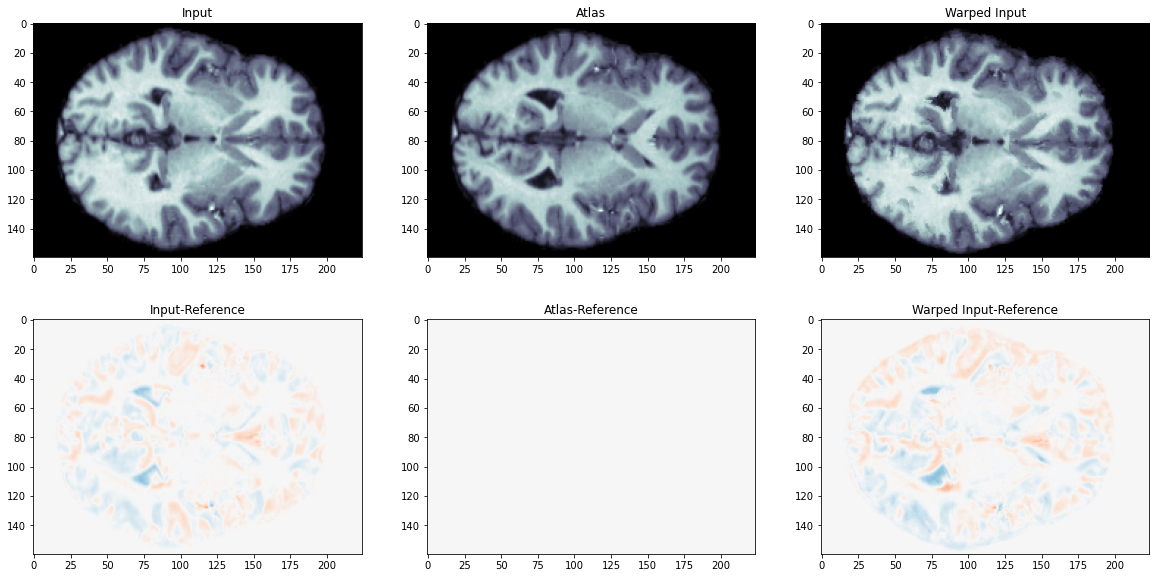

In [50]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
mid_slice = X_vol.shape[2]//2
max_diff = np.max(np.abs(X_vol - Y_vol))
for (ax1, ax2), c_vol, c_label in zip(
    m_axs.T, 
    [Y_vol, X_vol, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
    
):
    ax2.imshow(c_vol[0, :, mid_slice, :, 0] - X_vol[0, :, mid_slice, :, 0], 
               cmap = 'RdBu', vmin = -max_diff, vmax = max_diff)
    ax1.set_title(c_label)
    ax1.imshow(c_vol[0, :, mid_slice, :, 0], cmap = 'bone')
    ax2.set_title('{}-Reference'.format(c_label))

## MSK Sample Data

In [51]:
path = '../MSK-Image-Registration/data/'
from PIL import Image

In [63]:
img1_path = path + 'knee1FS time1 337172.nii-resize.tif'
img2_path = path + 'knee1FS time2 338366.nii-resize.tif'
img3_path = path + 'Knee2NFS Time1 20090305.nii.gz'
img4_path = path + 'Knee2NFS Time2 20140523.nii.gz'

img1Obj = Image.open(img1_path)
img2Obj = Image.open(img2_path)

h,w = np.shape(img1Obj)
img1 = np.zeros((h, w, img1Obj.n_frames))
img2 = np.zeros((h, w, img1Obj.n_frames))

for i in range(img1Obj.n_frames):
    img1Obj.seek(i)
    img1[:,:,i] = np.array(img1Obj)
    
for i in range(img2Obj.n_frames):
    img2Obj.seek(i)
    img2[:,:,i] = np.array(img2Obj)

img3Obj = nib.load(img3_path)
img4Obj = nib.load(img4_path)

img1 = np.expand_dims(np.expand_dims(img1,axis=0), axis=-1)
img2 = np.expand_dims(np.expand_dims(img2,axis=0), axis=-1)
im30 = np.expand_dims(img3Obj.get_fdata(),axis=0)
im40 = np.expand_dims(img4Obj.get_fdata(),axis=0)

print(img1.shape, img2.shape)
print(im30.shape, im40.shape)

atlas = img1.copy()
X_vol = img2.copy()

atlas_max = np.amax(atlas)
atlas_min = np.amin(atlas)
atlas_range = atlas_max - atlas_min
for i in range(atlas.shape[1]):
    for j in range(atlas.shape[2]):
        for k in range(atlas.shape[3]):
            atlas[0, i, j, k, 0] = atlas[0, i, j, k, 0] - atlas_min
            atlas[0, i, j, k, 0] = atlas[0, i, j, k, 0] / atlas_range
            
X_vol_max = np.amax(X_vol)
X_vol_min = np.amin(X_vol)
X_vol_range = X_vol_max - X_vol_min
for i in range(X_vol.shape[1]):
    for j in range(X_vol.shape[2]):
        for k in range(X_vol.shape[3]):
            X_vol[0, i, j, k, 0] = X_vol[0, i, j, k, 0] - X_vol_min
            X_vol[0, i, j, k, 0] = X_vol[0, i, j, k, 0] / X_vol_range

print(np.amax(atlas))
print(np.amin(atlas))
print(np.amax(X_vol))
print(np.amin(X_vol))
print(X_vol[0,:,:,:,0])

(1, 160, 192, 224, 1) (1, 160, 192, 224, 1)
(1, 320, 320, 192, 1) (1, 320, 320, 192, 1)
1.0
0.0
1.0
0.0
[[[0.00096993 0.         0.         ... 0.00193986 0.00096993 0.00096993]
  [0.0029098  0.00193986 0.00193986 ... 0.00484966 0.0029098  0.0029098 ]
  [0.0029098  0.00193986 0.00096993 ... 0.00484966 0.00484966 0.00581959]
  ...
  [0.00193986 0.00193986 0.00193986 ... 0.0029098  0.00096993 0.0029098 ]
  [0.00387973 0.0029098  0.00193986 ... 0.0029098  0.00193986 0.00193986]
  [0.00096993 0.00096993 0.00096993 ... 0.0029098  0.0029098  0.00387973]]

 [[0.00193986 0.00193986 0.00193986 ... 0.0029098  0.00193986 0.00096993]
  [0.00387973 0.00387973 0.00387973 ... 0.00872939 0.00678952 0.00484966]
  [0.00387973 0.0029098  0.00387973 ... 0.00969932 0.00872939 0.00678952]
  ...
  [0.0029098  0.00387973 0.00387973 ... 0.00581959 0.00581959 0.00969932]
  [0.00387973 0.00484966 0.00387973 ... 0.00581959 0.00678952 0.00581959]
  [0.0029098  0.00387973 0.00387973 ... 0.00581959 0.00581959 0.0077

### Before Resizing
* Target Image

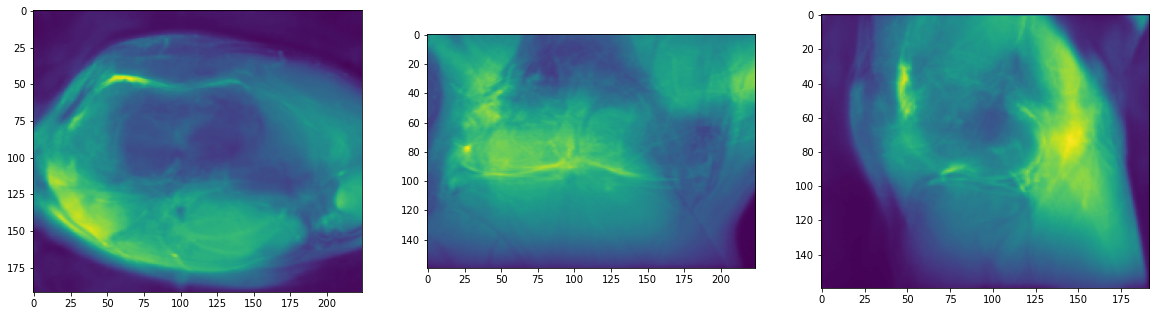

In [64]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas[0, :, :, :, 0], 0))
ax2.imshow(np.mean(atlas[0, :, :, :, 0], 1))
ax3.imshow(np.mean(atlas[0, :, :, :, 0], 2))

* Moving Image

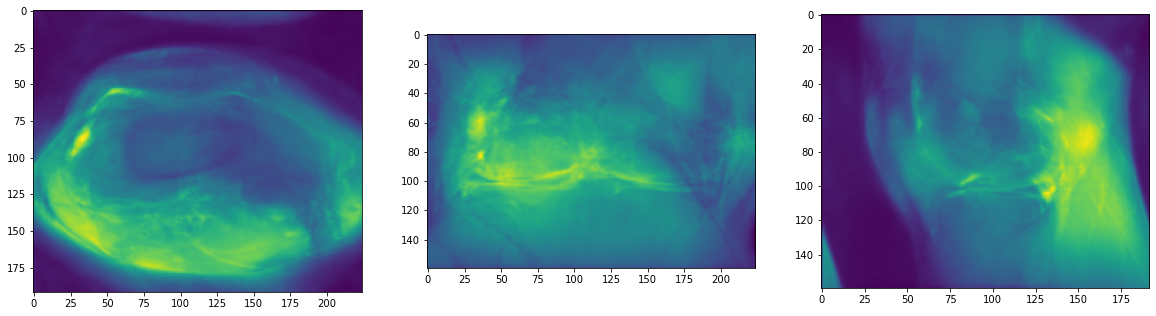

In [65]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(X_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(X_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(X_vol[0, :, :, :, 0], 2))

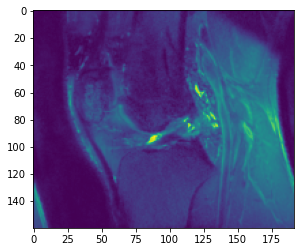

In [72]:
plt.imshow(X_vol[0,:,:,110,0])

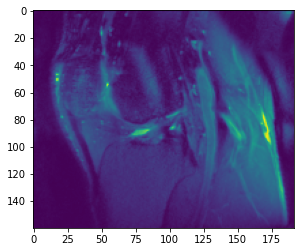

In [73]:
plt.imshow(atlas[0,:,:,100,0])

### Registration

In [74]:
%%time
pred_MSK = net.predict([X_vol, atlas])
print(len(pred_MSK))

2
Wall time: 4.46 s


### Show displacement map

19.444687
2.5037353


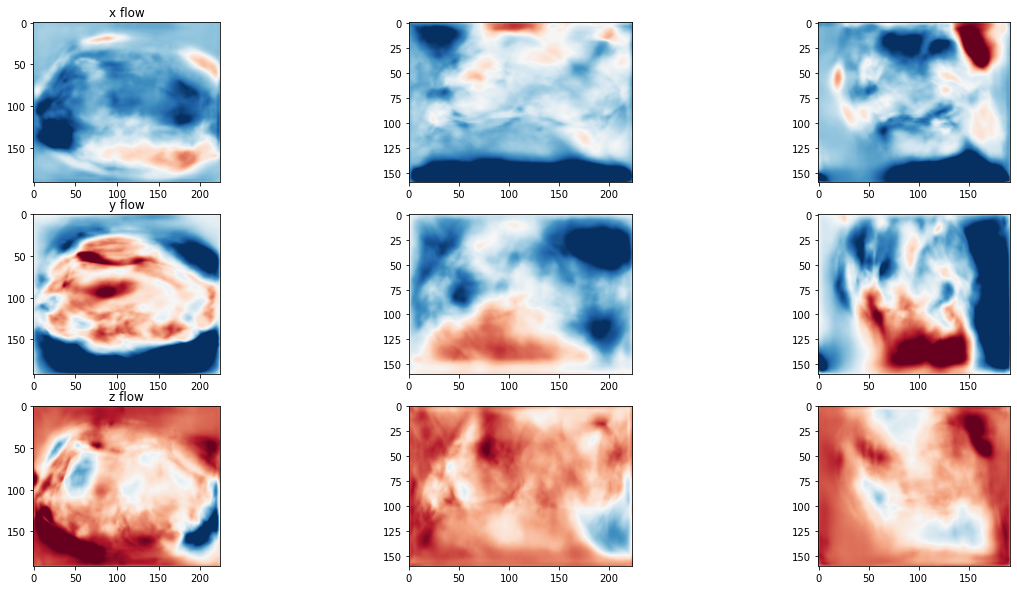

In [75]:
# Warp segments with flow
flow = pred_MSK[1][0, :, :, :, :]

flow_sd = np.std(flow)
print(np.amax(flow))
print(flow_sd)

v_args = dict(cmap = 'RdBu', vmin = -flow_sd, vmax = +flow_sd)

fig, m_axs = plt.subplots(3, 3, figsize = (20, 10)) # 9 figures

for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(np.mean(flow[:, :, :, i], 0), **v_args)
    ax1.set_title('xyz'[i]+' flow')
    ax2.imshow(np.mean(flow[:, :, :, i], 1), **v_args)
    ax3.imshow(np.mean(flow[:, :, :, i], 2), **v_args)
    

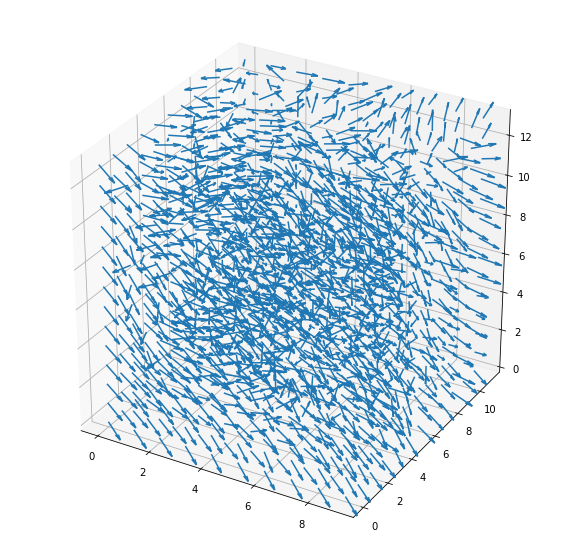

In [76]:
from mpl_toolkits.mplot3d import axes3d
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.9,
          normalize=True)

(160, 192, 224)


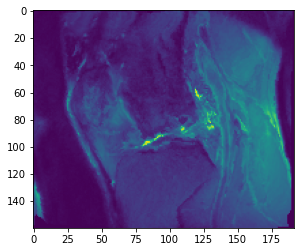

In [77]:
flow = pred_MSK[1][0, :, :, :, :]
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
warp_vol = interpn((yy, xx, zz), X_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)
print(warp_vol.shape)
plt.imshow(warp_vol[:,:,110])

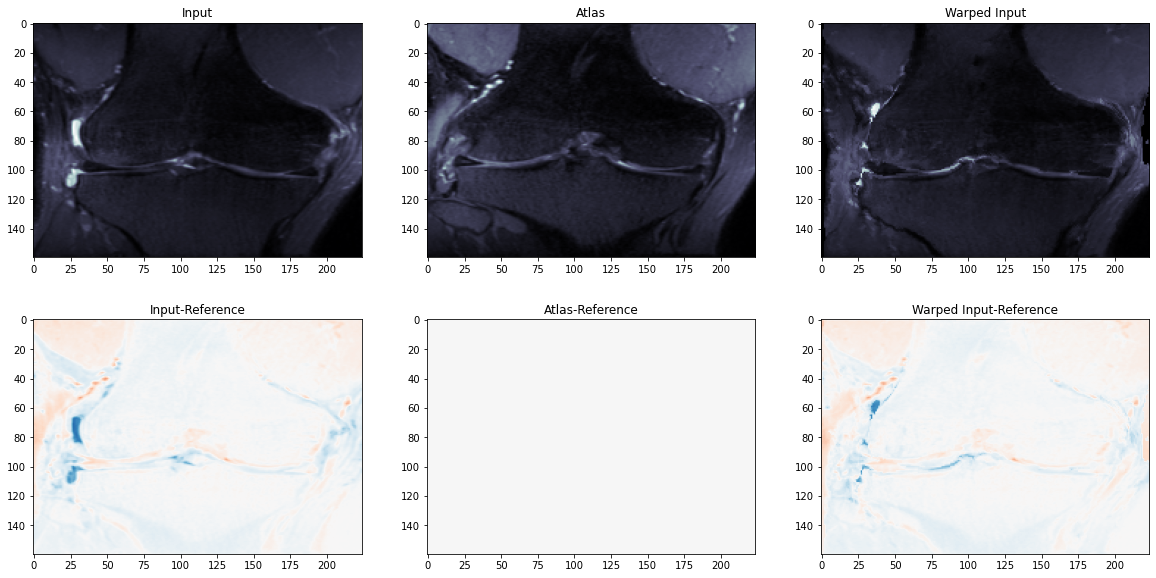

In [78]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
mid_slice = X_vol.shape[2]//2
max_diff = np.max(np.abs(atlas - X_vol))
for (ax1, ax2), c_vol, c_label in zip(
    m_axs.T, 
    [X_vol, atlas, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
):
    ax2.imshow(c_vol[0, :, mid_slice, :, 0] - atlas[0, :, mid_slice, :, 0], 
               cmap = 'RdBu', vmin = -max_diff, vmax = max_diff)
    ax1.set_title(c_label)
    ax1.imshow(c_vol[0, :, mid_slice, :, 0], cmap = 'bone')
    ax2.set_title('{}-Reference'.format(c_label))

In [23]:
import glob

In [24]:
train_vol_names = glob.glob(os.path.join(vm_dir, 'data', '*.npz'))

In [30]:
print(type(train_vol_names))
print(len(train_vol_names))
print(train_vol_names)

<class 'list'>
6
['./../data\\atlas_class_mapping.npz', './../data\\atlas_norm.npz', './../data\\meanstats_T1_WARP.npz', './../data\\prob_atlas_41_class.npz', './../data\\test_seg.npz', './../data\\test_vol.npz']


In [3]:
sourceImg = nib.load('../../MSK-Image-Registration/data/knee1FS time1 337172.nii')

In [4]:
sourceImg = sourceImg.get_fdata()

In [5]:
print(sourceImg.shape)

(320, 320, 192, 1)


In [6]:
sourceImg = np.reshape(sourceImg, (320, 320, 192))
print(sourceImg.shape)

(320, 320, 192)


In [7]:
np.savez('../../MSK-Image-Registration/data/knee1time1.npz', vol = sourceImg)

In [8]:
moving_path = '../../MSK-Image-Registration/data/knee1FS time1 337172.nii.gz'
target_path = '../../MSK-Image-Registration/data/knee1FS time2 338366.nii.gz'

In [9]:
movingObj = nib.load(moving_path)
targetObj = nib.load(target_path)

In [10]:
mov_img = np.expand_dims(movingObj.get_fdata(),axis=0)
tar_img = np.expand_dims(targetObj.get_fdata(),axis=0)

In [11]:
print(mov_img.shape)
print(tar_img.shape)
X_vol = mov_img
atlas = tar_img

# Normalization
atlas_max = np.amax(atlas)
atlas_min = np.amin(atlas)
atlas_range = atlas_max - atlas_min
for i in range(atlas.shape[1]):
    for j in range(atlas.shape[2]):
        for k in range(atlas.shape[3]):
            atlas[0, i, j, k, 0] = atlas[0, i, j, k, 0] - atlas_min
            atlas[0, i, j, k, 0] = atlas[0, i, j, k, 0] / atlas_range
            
X_vol_max = np.amax(X_vol)
X_vol_min = np.amin(X_vol)
X_vol_range = X_vol_max - X_vol_min
for i in range(X_vol.shape[1]):
    for j in range(X_vol.shape[2]):
        for k in range(X_vol.shape[3]):
            X_vol[0, i, j, k, 0] = X_vol[0, i, j, k, 0] - X_vol_min
            X_vol[0, i, j, k, 0] = X_vol[0, i, j, k, 0] / X_vol_range

(1, 320, 320, 192, 1)
(1, 320, 320, 192, 1)


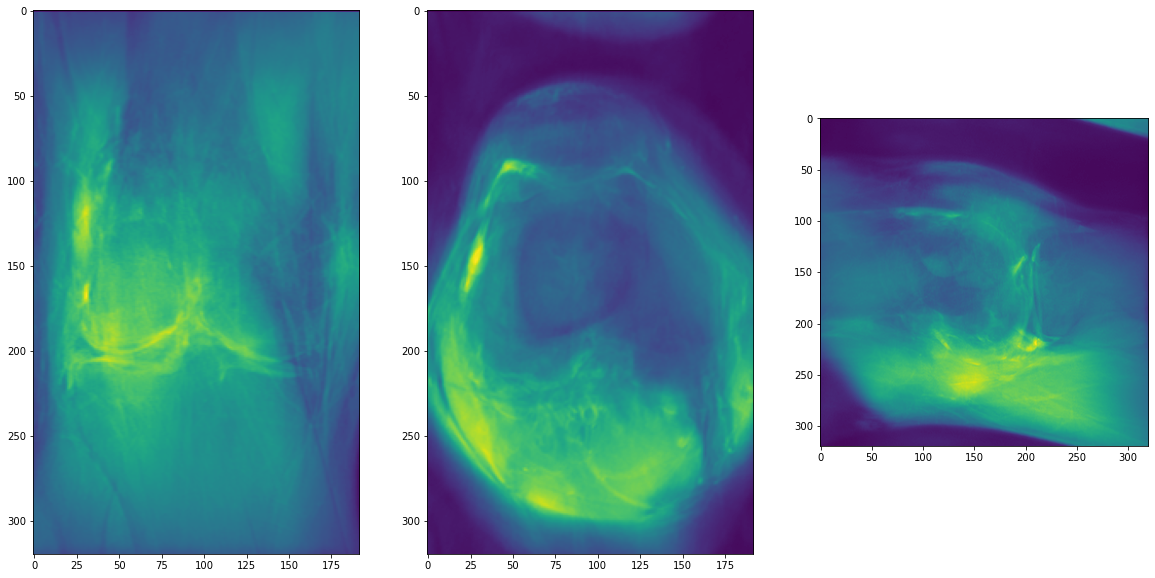

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(atlas[0, :, :, :, 0], 0))
ax2.imshow(np.mean(atlas[0, :, :, :, 0], 1))
ax3.imshow(np.mean(atlas[0, :, :, :, 0], 2))

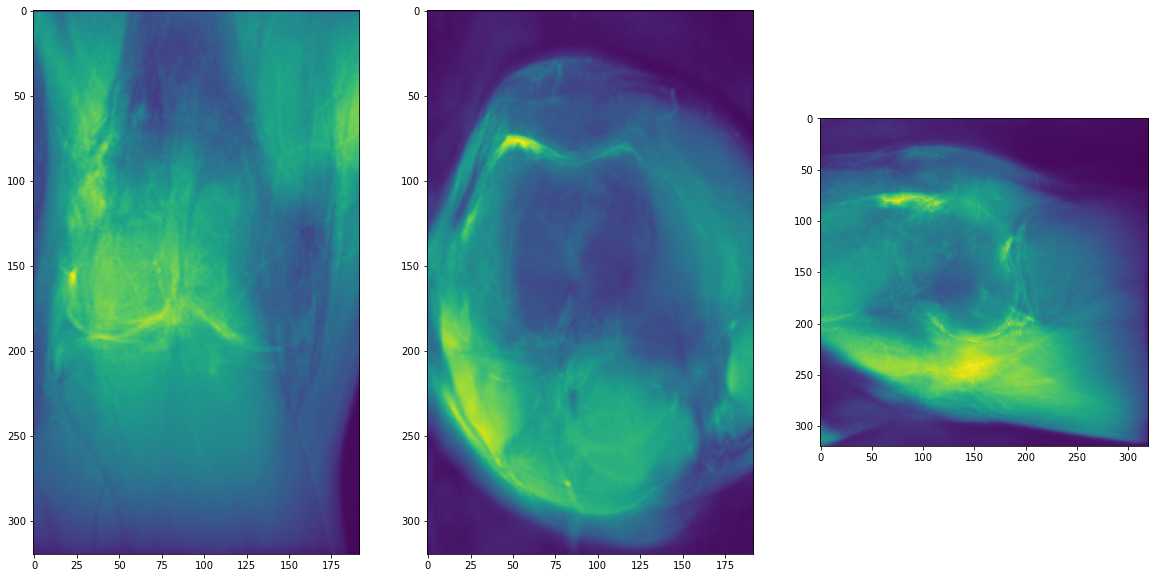

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 10))
ax1.imshow(np.mean(X_vol[0, :, :, :, 0], 0))
ax2.imshow(np.mean(X_vol[0, :, :, :, 0], 1))
ax3.imshow(np.mean(X_vol[0, :, :, :, 0], 2))

In [14]:
mdl = os.path.join(vm_dir, 'models', 'test', '00.h5') # Pretrained model 

custom_objects = {'SpatialTransformer': nrn_layers.SpatialTransformer,
                 'VecInt': nrn_layers.VecInt,
                 'Sample': networks.Sample,
                 'Rescale': networks.RescaleDouble,
                 'Resize': networks.ResizeDouble,
                 'Negate': networks.Negate,
                 'recon_loss': losses.Miccai2018(0.02, 10).recon_loss, # values shouldn't matter
                 'kl_loss': losses.Miccai2018(0.02, 10).kl_loss        # values shouldn't matter
                 }
net = keras.models.load_model(mdl, custom_objects=custom_objects)




Here









C:\Users\Yixing\Anaconda3\envs\voxelmorph\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [15]:
%%time
pred_MSK_2 = net.predict([X_vol, atlas])

Wall time: 13 s


19.7707
2.273411


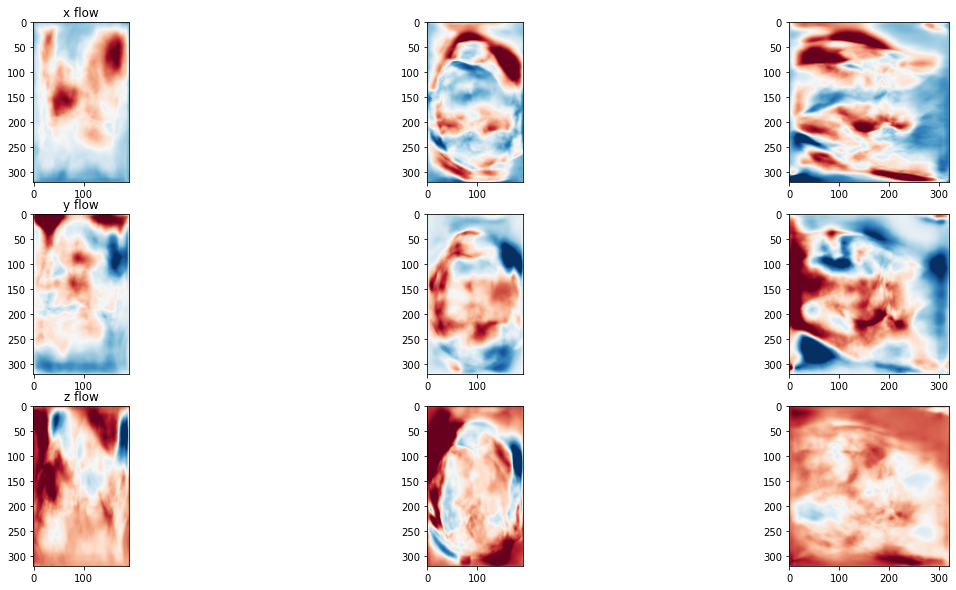

In [16]:
# Warp segments with flow
flow = pred_MSK_2[1][0, :, :, :, :]

flow_sd = np.std(flow)
print(np.amax(flow))
print(flow_sd)

v_args = dict(cmap = 'RdBu', vmin = -flow_sd, vmax = +flow_sd)

fig, m_axs = plt.subplots(3, 3, figsize = (20, 10)) # 9 figures

for i, (ax1, ax2, ax3) in enumerate(m_axs):
    ax1.imshow(np.mean(flow[:, :, :, i], 0), **v_args)
    ax1.set_title('xyz'[i]+' flow')
    ax2.imshow(np.mean(flow[:, :, :, i], 1), **v_args)
    ax3.imshow(np.mean(flow[:, :, :, i], 2), **v_args)

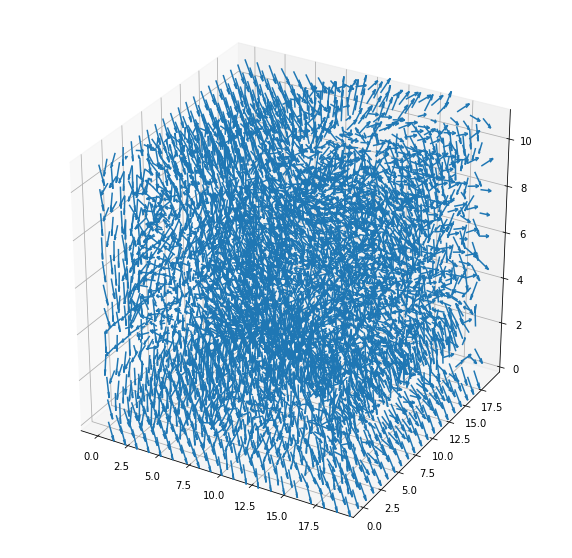

In [21]:
from mpl_toolkits.mplot3d import axes3d
DS_FACTOR = 16
c_xx, c_yy, c_zz = [x.flatten()
                    for x in 
                    meshgridnd_like(flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, 0])]

get_flow = lambda i: flow[::DS_FACTOR, ::DS_FACTOR, ::DS_FACTOR, i].flatten()

fig = plt.figure(figsize = (10, 10))
ax = fig.gca(projection='3d')

ax.quiver(c_xx,
          c_yy,
          c_zz,
          get_flow(0),
          get_flow(1), 
          get_flow(2), 
          length=0.9,
          normalize=True)

In [18]:
vol_size = (320, 320, 192)
xx = np.arange(vol_size[1])
yy = np.arange(vol_size[0])
zz = np.arange(vol_size[2])
grid = np.rollaxis(np.array(np.meshgrid(xx, yy, zz)), 0, 4)
sample = flow+grid
sample = np.stack((sample[:, :, :, 1], sample[:, :, :, 0], sample[:, :, :, 2]), 3)
warp_vol = interpn((yy, xx, zz), X_vol[0, :, :, :, 0], sample, method='nearest', bounds_error=False, fill_value=0)

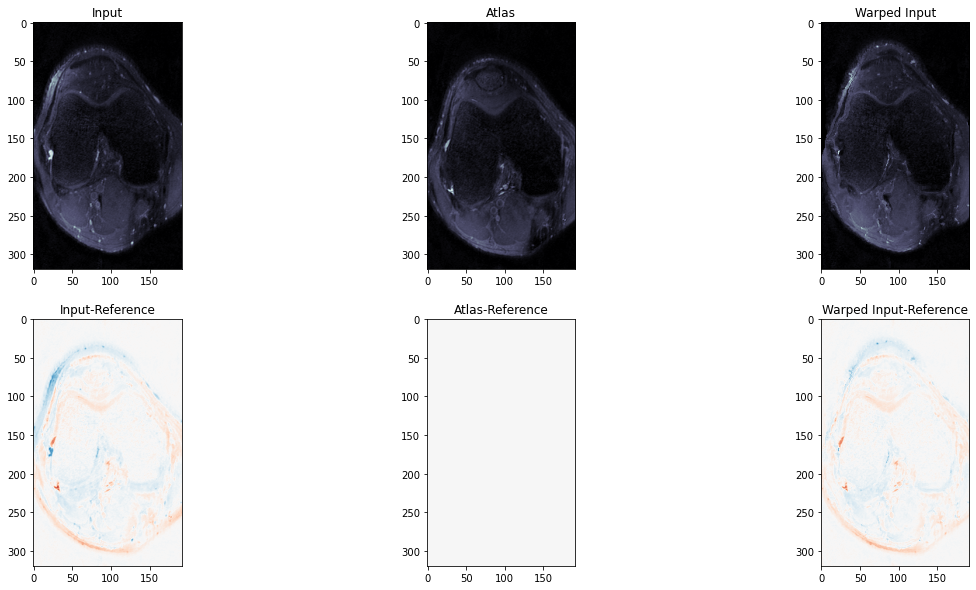

In [19]:
fig, m_axs = plt.subplots(2, 3, figsize = (20, 10))
mid_slice = X_vol.shape[2]//2
max_diff = np.max(np.abs(atlas - X_vol))
for (ax1, ax2), c_vol, c_label in zip(
    m_axs.T, 
    [X_vol, atlas, np.expand_dims(np.expand_dims(warp_vol, 0), -1)], 
    ['Input', 'Atlas', 'Warped Input']
):
    ax2.imshow(c_vol[0, :, mid_slice, :, 0] - atlas[0, :, mid_slice, :, 0], 
               cmap = 'RdBu', vmin = -max_diff, vmax = max_diff)
    ax1.set_title(c_label)
    ax1.imshow(c_vol[0, :, mid_slice, :, 0], cmap = 'bone')
    ax2.set_title('{}-Reference'.format(c_label))